In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from collections import Counter
from tqdm import tqdm
import os
import io

In [2]:
import community as community_louvain
from scipy.io import mmread
from scipy.sparse import issparse

In [3]:
data_path = 'socfb-Auburn71/socfb-Auburn71.mtx'
sparse_matrix = mmread(data_path)

In [4]:
G = nx.from_scipy_sparse_array(sparse_matrix)

In [5]:
G = G.to_undirected()

In [6]:
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
G_core = nx.k_core(G, k=95)
# Run the Louvain algorithm on your K-75 core
# This returns a dictionary: {node_id: community_id}
partition = community_louvain.best_partition(G_core)

# Add this information to the graph nodes
# Gephi will see this as a new column called "Modularity Class"
nx.set_node_attributes(G_core, partition, "Modularity Class")


N = G_core.number_of_nodes()
M = G_core.number_of_edges()

print(f"N: {N}")
print(f"M: {M}")



N: 1011
M: 78470


In [ ]:
# The GEXF format will automatically include the "Modularity Class" column
nx.write_gexf(G_core, "socfb-Auburn71.gexf")

print(f"Graph saved with {len(set(partition.values()))} distinct communities detected.")



Graph saved with 7 distinct communities detected.


In [11]:
# Average Degree
degrees = [d for n, d in G_core.degree()]
avg_degree = sum(degrees) / N

# Density
density = nx.density(G_core)

# Average Clustering Coefficient
avg_clustering = nx.average_clustering(G_core)

In [13]:
print(f"Average Degree: {avg_degree}")
print(f"Density: {density}")
print(f"Average Clustering Coefficient: {avg_clustering}")


Average Degree: 155.2324431256182
Density: 0.15369548824318632
Average Clustering Coefficient: 0.4177821431564032


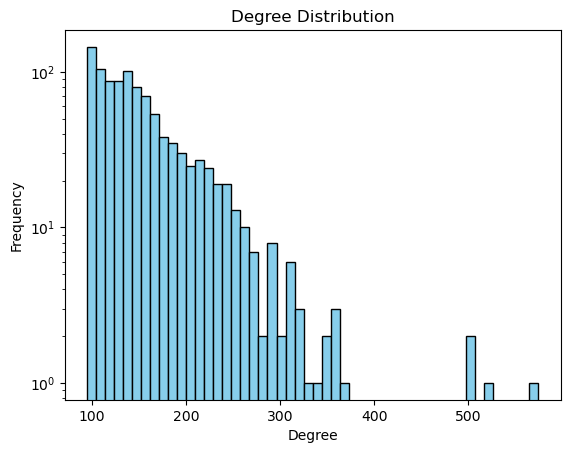

In [18]:
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')

In [9]:
# Degree Centrality (Who has the most friends in this elite group?)
degree_dict = nx.degree_centrality(G_core)
top_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

# Eigenvector Centrality (Who is connected to other VIPs?)
# We increase max_iter because the K-95 core is very dense
eigen_dict = nx.eigenvector_centrality(G_core, max_iter=1000)
top_eigen = sorted(eigen_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("--- Top 5 Nodes by Degree (Popularity) ---")
for node, val in top_degree:
    print(f"Node {node}: {val:.4f}")

print("\n--- Top 5 Nodes by Eigenvector (Influence) ---")
for node, val in top_eigen:
    print(f"Node {node}: {val:.4f}")

--- Top 5 Nodes by Degree (Popularity) ---
Node 5471: 0.5683
Node 10076: 0.5119
Node 3211: 0.5010
Node 14496: 0.4931
Node 16368: 0.3673

--- Top 5 Nodes by Eigenvector (Influence) ---
Node 5471: 0.0985
Node 10076: 0.0981
Node 3211: 0.0959
Node 14496: 0.0886
Node 16368: 0.0737


In [19]:
print("Calculating Betweenness Centrality on G_core...")

betweenness_dict = nx.betweenness_centrality(G_core) 
top_betweenness = sorted(betweenness_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n--- Top 5 Nodes by Betweenness (Gatekeepers) ---")
for node, val in top_betweenness:
    print(f"Node {node}: {val:.4f}")

Calculating Betweenness Centrality on G_core...

--- Top 5 Nodes by Betweenness (Gatekeepers) ---
Node 5471: 0.0214
Node 14496: 0.0138
Node 3211: 0.0113
Node 10076: 0.0107
Node 16368: 0.0051


In [21]:
print("--- SECTION C: LARGE-SCALE STRUCTURE ---")

# 1. Modularity (Community Structure)
modularity_score = community_louvain.modularity(partition, G_core)
print(f"Modularity Score: {modularity_score:.4f}")

# Count the communities
from collections import Counter
community_counts = Counter(partition.values())
sorted_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)

print(f"Number of Communities Detected: {len(sorted_counts)}")
print("Top 5 Largest Communities (Size):")
for comm_id, size in sorted_counts[:5]:
    print(f"  Community {comm_id}: {size} students")

# 2. Assortativity (Do popular people hang out together?)
assortativity = nx.degree_assortativity_coefficient(G_core)
print(f"\nAssortativity Coefficient: {assortativity:.4f}")

--- SECTION C: LARGE-SCALE STRUCTURE ---
Modularity Score: 0.3854
Number of Communities Detected: 7
Top 5 Largest Communities (Size):
  Community 3: 206 students
  Community 2: 170 students
  Community 4: 161 students
  Community 5: 150 students
  Community 6: 144 students

Assortativity Coefficient: 0.0127
